In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
import numpy as np
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image
import pandas as pd

import sys
sys.path.append("../../../src/")
sys.path.append("../../")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from utils.visualizations.visualize import concat_imgs, preprocess_arrays

import pytorch_ssim
import pandas as pd
import numpy as np

## Test function

#### mMetric_v1

In [3]:
def mMetric_v1(ori_activation_maps, opt_activation_maps, selected_filter,
               co1=1, co2=10000):
    """Metric, the first version.
    Args:
        ori_activation_maps: [batch_size, channels, height, width]
        opt_activation_maps: [batch_size, channels, height, width]
    """
    ori = ori_activation_maps.copy()
    opt = opt_activation_maps.copy()
    diff = ori_activation_maps-opt_activation_maps

    diff_sel = diff[:, selected_filter]
    ori_sel = ori[:, selected_filter]
    opt_sel = opt[:, selected_filter]
    opt_res = np.concatenate((opt[:, : selected_filter],
                              opt[:, selected_filter+1:]), axis=1)
    ori_res = np.concatenate((ori[:, : selected_filter],
                              ori[:, selected_filter+1:]), axis=1)

    (batch_size, channels, height, width) = ori.shape

    # SF term.
    SF_0 = np.sum(diff_sel == 0, axis=(1, 2))
    pixel_per_image = height * width
    SF_term = SF_0 / pixel_per_image
    print("=> SF_0: {}".format(SF_0))
    print("=> pixel_per_image: {}".format(pixel_per_image))
    print("=> SF_term: {}".format(SF_term))

    # RF term.
    ori_sel = np.expand_dims(ori_sel, axis=1)
#     print("ori_sel: ", ori_sel.shape)
    ori_sel = np.repeat(ori_sel, channels-1, axis=1)
#     print("ori_sel: ", ori_sel.shape)
    ori_sel_mask = ori_sel == 0
    opt_res = opt_res == 0
    opt_res = opt_res * ori_sel_mask
    pixel_per_image = np.sum(ori_sel_mask, axis=(1, 2, 3))
    RF_0_non_overlap = np.sum(opt_res == 1, axis=(1, 2, 3))
    RF_term = RF_0_non_overlap / pixel_per_image
    print("=> FF_0: {}".format(RF_0_non_overlap))
    print("=> pixel_per_image: {}".format(pixel_per_image))
    print("=> FF_term: {}".format(RF_term))

    over_metric = (co1 * SF_term + co2 * RF_term) / (co1 + co2)
    return over_metric

#### mMetirc_v2

In [4]:
def mMetric_v2(ori_activation_maps, opt_activation_maps, selected_filter,
               co1=1, co2=1):
    """Metric, the first version.
    Args:
        ori_activation_maps: [batch_size, channels, height, width]
        opt_activation_maps: [batch_size, channels, height, width]
    """
    ori = ori_activation_maps.copy()
    opt = opt_activation_maps.copy()
    diff = ori_activation_maps-opt_activation_maps

    diff_sel = diff[:, selected_filter]
    ori_sel = ori[:, selected_filter]
    opt_sel = opt[:, selected_filter]
    opt_res = np.concatenate((opt[:, : selected_filter],
                              opt[:, selected_filter+1:]), axis=1)
    ori_res = np.concatenate((ori[:, : selected_filter],
                              ori[:, selected_filter+1:]), axis=1)

    (batch_size, channels, height, width) = ori.shape
    pixel_per_image = height * width

    # SF term.
    
    diff_sel = np.reshape(diff_sel, (batch_size, -1))
    diff_sel = diff_sel - np.amax(diff_sel, axis=1, keepdims=True)
    diff_sel = np.exp(diff_sel)
    print(diff_sel)
    SF_0 = (diff_sel / diff_sel.sum(axis=1, keepdims=True)).mean(axis=1)
    SF_term = 1 - SF_0 / pixel_per_image
    print("=> SF_0: {}".format(SF_0))
    print("=> pixel_per_image: {}".format(pixel_per_image))
    print("=> SF_term: {}".format(SF_term))

    # RF term.
    ori_sel = np.expand_dims(ori_sel, axis=1)
    print("ori_sel: ", ori_sel.shape)
    ori_sel = np.repeat(ori_sel, channels-1, axis=1)
    print("ori_sel: ", ori_sel.shape)
    ori_sel_mask = ori_sel == 0
    opt_res = opt_res == 0
    opt_res = opt_res * ori_sel_mask
    pixel_per_image = np.sum(ori_sel_mask, axis=(1, 2, 3))
    RF_0_non_overlap = np.sum(opt_res == 1, axis=(1, 2, 3))
    RF_term = RF_0_non_overlap / pixel_per_image
    print("=> FF_0: {}".format(RF_0_non_overlap))
    print("=> pixel_per_image: {}".format(pixel_per_image))
    print("=> FF_term: {}".format(RF_term))

    over_metric = (co1 * SF_term + co2 * RF_term) / (co1 + co2)
    return over_metric

#### mMetric_v3

In [5]:
def mMetric_v3(ori_activation_maps, opt_activation_maps, selected_filter,
               co1=1, co2=1):
    ori = ori_activation_maps.copy()
    opt = opt_activation_maps.copy()
    diff = ori_activation_maps-opt_activation_maps

    diff_sel = diff[:, selected_filter]
    ori_sel = ori[:, selected_filter]
    opt_sel = opt[:, selected_filter]
    opt_res = np.concatenate((opt[:, : selected_filter],
                              opt[:, selected_filter+1:]), axis=1)
    ori_res = np.concatenate((ori[:, : selected_filter],
                              ori[:, selected_filter+1:]), axis=1)

    (batch_size, channels, height, width) = ori.shape

    ori_sel_ts = torch.from_numpy(ori_sel).unsqueeze(dim=1).cuda()
    opt_sel_ts = torch.from_numpy(opt_sel).unsqueeze(dim=1).cuda()
    
    ssim_sel = []
    rmses = []
    for index in range(30):
        ssim = pytorch_ssim.ssim(ori_sel_ts[index].unsqueeze(dim=0), 
                                 opt_sel_ts[index].unsqueeze(dim=0)).cpu().numpy()
        rmse = torch.sqrt(((ori_sel_ts[index].unsqueeze(dim=0)-
                         opt_sel_ts[index].unsqueeze(dim=0)) ** 2).mean()).cpu().numpy()
        ssim_sel.append(ssim)
        rmses.append(rmse)
        # ssim_loss = pytorch_ssim.SSIM(window_size=11)
        # print(ssim_loss(ori_sel, opt_sel))

    # RF
    ori_sel = np.expand_dims(ori_sel, axis=1)
    #print("ori_sel: ", ori_sel.shape)
    ori_sel = np.repeat(ori_sel, channels-1, axis=1)
    #print("ori_sel: ", ori_sel.shape)
    ori_sel_mask = ori_sel == 0
    opt_res_mask = opt_res != 0
    new_opt_res = opt_res * ori_sel_mask * opt_res_mask
    opt_res_ts = torch.from_numpy(new_opt_res).cuda()
    #print(opt_res_ts.shape)
    zero_mask = torch.zeros_like(opt_res_ts).cuda()
    
    ssim_res = []
    for index in range(30):
        ssim = pytorch_ssim.ssim(opt_res_ts[index].unsqueeze(dim=0), 
                                 zero_mask[index].unsqueeze(dim=0)).cpu().numpy()
        ssim_res.append(ssim)
    print("RMSE: {} - std {}".format(np.mean(rmses), np.std(rmses)))
    print("SSIM_SEL: {} - std {}".format(np.mean(ssim_sel), np.std(ssim_sel)))
    print("SSIM_RES: {} - std {}".format(np.mean(ssim_res), np.std(ssim_res)))
    lamba1 = 0.5
    lamba2 = 0.5
    ssim_sum = lamba1 * np.array(ssim_sel) + lamba2 * np.array(ssim_res)
    print("SSIM_SUM {} - std {}".format(np.mean(ssim_sum), np.std(ssim_sum)))

## Main

In [25]:
def main(exp, selected_layer, selected_filter, class_index=950):
    num_class = 30
    class_index = class_index
    print("=> class index: {}".format(class_index))
    backbone = "vgg16"
    resume = "037-0"
    color_map = "jet"
    model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    ## Load modal from dict
    
    # model
    net = model.Network(backbone=backbone, num_classes=1000, 
                        selected_layer=selected_layer)
    net.to(device)
    
    # resume from model
    resume_exp = resume.split("-")[0]
    resume_epoch = resume.split("-")[1]
    print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
    resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
    ckpt = torch.load(resume_path, map_location=device)
    net.load_state_dict(ckpt, strict=False) 
    
    #summary(net, (3, 224, 224))
    
    ## Load Original Data 
    
    # Load data
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    train_transform = None
    train_transform = transforms.Compose([                                                                                                                                
        transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
        transforms.ToTensor(),                                                                                                                                            
        #transforms.Normalize(mean, std)                                                                                                                                   
           ])         
    trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                                 is_train=True, transform=train_transform)
    
    trainset.set_data([class_index], num_class)
    imgs_path = []                                                                                                                                                            
    images = []
    labels = []
    for img, label, img_path in trainset:                                                                                                                                     
        images.append(img.unsqueeze(0))                                                                                                                                       
        labels.append(label)                                                                                                                                                  
        imgs_path.append(img_path)  
    
    ## Create some need path
    
    save_dir = "../../../saved/pack/"
    ################### Hyper-Parameter #######################
    # exp = resume_exp
    # epoch = resume_epoch
    ##########################################################
    ab_path = os.path.join(save_dir, exp)
    
    index2image = {index: item.split("/")[-1].split(".")[0] for index, item in enumerate(imgs_path)}
    
    images_cpu = np.array([image.detach().clone().cpu().numpy().squeeze() for image in images])
    
    # Load image
    # ext may be different.
    optimized_data, valid_imgs_path, valid_imgs_index = load_imgs(ab_path, imgs_path, non_exists_ok=True, ext=".png")
    valid_imgs, valid_labels = extract_valid(images, labels, valid_imgs_index)
    optimized_data_zscore = zscore(optimized_data, mean, std)
    images_zscore = zscore(images_cpu, mean, std)
    
    # Move to device
    opt_image = torch.from_numpy(optimized_data_zscore).to(device)
    original_image = torch.from_numpy(images_zscore).to(device)
    
    ## Obtain feature from conv layers.
    
    ori_activation_maps = net.get_activation_maps(original_image, 
                                                  selected_layer=selected_layer)[0]
    opt_activation_maps = net.get_activation_maps(opt_image, 
                                                  selected_layer=selected_layer)[0]
    return ori_activation_maps, opt_activation_maps
    

#### L1F16

In [7]:
exp = "052490"
selected_layer = 1
selected_filter = 16
class_index = 950
ori_activation_maps, opt_activation_maps = main(exp, selected_layer, 
                                                selected_filter, class_index)

=> class index: 950
Only Keep 1th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/052490
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 1
=> Register fhook 1


##### mMetric_v1

In [8]:
over_metric = mMetric_v1(ori_activation_maps, ori_activation_maps, selected_filter=selected_filter)
print(over_metric)
print(np.mean(over_metric))

=> SF_0: [50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176
 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176
 50176 50176 50176 50176 50176 50176]
=> pixel_per_image: 50176
=> SF_term: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
=> FF_0: [453395 109037  12123 452315  14013 663615 583531  96544 670105  39951
 288965 376549 219015 858200 264397   8197 226341   5847 569514 240148
  69362 167154  56745 228009  13814  19998 268259 300016 221406 214275]
=> pixel_per_image: [1151136  216972   27405  986769   31185 1849680 1665468  236439 1653057
   78876  650412  910476  638190 2529639  718956   18585  587727   13167
 1435959  660240  191331  436779  134505  496314   31626   41706  626535
  664587  741951  503181]
=> FF_term: [0.39386745 0.5025395  0.44236453 0.45837982 0.44935065 0.35877287
 0.35037059 0.40832519 0.4053732  0.50650388 0.44427993 0.41357378
 0.3431815  0.33925789 0.36775129 0.441054

In [9]:
over_metric = mMetric_v1(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)
print(over_metric)
print(np.mean(over_metric))

=> SF_0: [2817 1620   40 5115  111 1354  964  990 3058  724 3262 3116  378 1118
 1709    0 2487  100 1817 2145  993 1148  606 2447   69  294  488 4355
 1703 2795]
=> pixel_per_image: 50176
=> SF_term: [0.05614238 0.03228635 0.00079719 0.10194117 0.00221221 0.02698501
 0.01921237 0.01973055 0.06094547 0.01442921 0.06501116 0.0621014
 0.00753348 0.02228157 0.03406011 0.         0.04956553 0.00199298
 0.03621253 0.04274952 0.01979034 0.02287946 0.01207749 0.04876834
 0.00137516 0.00585938 0.00972577 0.08679448 0.03394053 0.05570392]
=> FF_0: [ 492798   97594   12228  427263   14617  794739  713764  104945  712065
   37374  283250  392341  273604 1084886  313137    8365  262264    5968
  615317  284171   83449  188036   58512  215085   14763   18907  268688
  286829  319588  220010]
=> pixel_per_image: [1151136  216972   27405  986769   31185 1849680 1665468  236439 1653057
   78876  650412  910476  638190 2529639  718956   18585  587727   13167
 1435959  660240  191331  436779  134505  49

##### mMetric_v2

In [10]:
over_metric = mMetric_v2(ori_activation_maps, ori_activation_maps, selected_filter=selected_filter)
print(over_metric)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
=> SF_0: [1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05]
=> pixel_per_image: 50176
=> SF_term: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
ori_sel:  (30, 1, 224, 224)
ori_sel:  (30, 63, 224, 224)
=> FF_0: [453395 109037  12123 452315  14013 663615 583531  96544 670105  39951
 288965 376549 219015 858200 264397   8197 226341   5847 569514 240148
  69362 167154  56745 228009  13814  19998 268259 300016 221406 21427

In [11]:
over_metric = mMetric_v2(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)
print(over_metric)

[[0.50780404 0.5092825  0.5071508  ... 0.5260068  0.5130839  0.5076022 ]
 [0.43216452 0.42466876 0.42422515 ... 0.42543408 0.4303236  0.42432106]
 [0.16058587 0.16749926 0.16849303 ... 0.17126307 0.17901869 0.16740999]
 ...
 [0.3918673  0.41037104 0.40676403 ... 0.4118166  0.42114702 0.4018169 ]
 [0.46618858 0.48951557 0.49279281 ... 0.5152079  0.5159618  0.48156777]
 [0.23295479 0.23363301 0.2326551  ... 0.23018847 0.23404068 0.23428014]]
=> SF_0: [1.9929845e-05 1.9929850e-05 1.9929847e-05 1.9929850e-05 1.9929847e-05
 1.9929847e-05 1.9929850e-05 1.9929850e-05 1.9929847e-05 1.9929847e-05
 1.9929850e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929845e-05
 1.9929847e-05 1.9929850e-05 1.9929847e-05 1.9929847e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929847e-05 1.9929845e-05 1.9929847e-05
 1.9929847e-05 1.9929847e-05 1.9929845e-05 1.9929850e-05 1.9929850e-05]
=> pixel_per_image: 50176
=> SF_term: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.

##### mMetric_v3

In [12]:
#over_metric = 
mMetric_v3(ori_activation_maps, ori_activation_maps, selected_filter=selected_filter)
#print(over_metric)
#print(np.mean(over_metric))

RMSE: 0.0 - std 0.0
SSIM_SEL: 1.0 - std 0.0
SSIM_RES: 0.7475038170814514 - std 0.16919776797294617
SSIM_SUM 0.8737518787384033 - std 0.08459888398647308


In [13]:
mMetric_v3(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)

RMSE: 0.17237147688865662 - std 0.17498500645160675
SSIM_SEL: 0.9007095098495483 - std 0.06958510726690292
SSIM_RES: 0.8071271777153015 - std 0.13045555353164673
SSIM_SUM 0.8539183139801025 - std 0.06818907707929611


### L3F28

In [14]:
exp = "7004"
selected_layer = 3
selected_filter = 28
class_index = 950
ori_activation_maps, opt_activation_maps = main(exp, selected_layer, 
                                                selected_filter, class_index)

=> class index: 950
Only Keep 3th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/7004
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 3
=> Register fhook 3


#### mMetric_v1

In [15]:
over_metric = mMetric_v1(ori_activation_maps, ori_activation_maps, selected_filter=selected_filter)
print(over_metric)
print(np.mean(over_metric))

=> SF_0: [50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176
 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176
 50176 50176 50176 50176 50176 50176]
=> pixel_per_image: 50176
=> SF_term: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
=> FF_0: [ 912666  773575  264145  608296  726332  941569  982697 1056030  680586
   48262 1513034 1197917  519385 1253848  351201   29712 1491286  327659
  291539  234548  556699  322950  827831  180334   53659   46614   13855
 1079197  528770  436783]
=> pixel_per_image: [1649403 1440684  526302 1130346 1348137 1804824 1628109 1970514 1270962
   91728 2681658 2119824  911673 2279214  600516   64386 2685312  624582
  551439  452466 1050147  608265 1541988  342153  107730   95634   24003
 1987335 1047249  779562]
=> FF_term: [0.55333111 0.53694981 0.50188865 0.53815027 0.5387672  0.52169574
 0.60358182 0.53591601 0.53548887 0.52614251 0.56421587 0.5651021
 0.56970537 

In [16]:
over_metric = mMetric_v1(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)
print(over_metric)
print(np.mean(over_metric))

=> SF_0: [11706 15159  5769 12004 16805 20958 20047 18794  9970  1218 24296 23768
 10262 29914  5682   631 23694  6254  4257  3588 11609  5008 13686  3662
  1201  1064   319 18847 10358  6258]
=> pixel_per_image: 50176
=> SF_term: [0.23329879 0.30211655 0.11497529 0.23923788 0.33492108 0.41768973
 0.39953364 0.37456154 0.19870057 0.02427455 0.48421556 0.4736926
 0.20452009 0.59618144 0.11324139 0.01257573 0.47221779 0.12464126
 0.08484136 0.07150829 0.23136559 0.09980867 0.27275989 0.0729831
 0.02393575 0.02120536 0.00635762 0.37561783 0.20643335 0.12472098]
=> FF_0: [ 957967  804719  309991  629867  819066 1097031  990218 1106851  731939
   49524 1570361 1257823  548208 1392729  354060   35098 1538888  354944
  318225  262445  623550  348101  889568  191442   60169   52728   14028
 1103962  620492  446338]
=> pixel_per_image: [1649403 1440684  526302 1130346 1348137 1804824 1628109 1970514 1270962
   91728 2681658 2119824  911673 2279214  600516   64386 2685312  624582
  551439  45246

In [17]:
mMetric_v1(ori_activation_maps, ori_activation_maps, selected_filter=selected_filter)

=> SF_0: [50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176
 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176 50176
 50176 50176 50176 50176 50176 50176]
=> pixel_per_image: 50176
=> SF_term: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
=> FF_0: [ 912666  773575  264145  608296  726332  941569  982697 1056030  680586
   48262 1513034 1197917  519385 1253848  351201   29712 1491286  327659
  291539  234548  556699  322950  827831  180334   53659   46614   13855
 1079197  528770  436783]
=> pixel_per_image: [1649403 1440684  526302 1130346 1348137 1804824 1628109 1970514 1270962
   91728 2681658 2119824  911673 2279214  600516   64386 2685312  624582
  551439  452466 1050147  608265 1541988  342153  107730   95634   24003
 1987335 1047249  779562]
=> FF_term: [0.55333111 0.53694981 0.50188865 0.53815027 0.5387672  0.52169574
 0.60358182 0.53591601 0.53548887 0.52614251 0.56421587 0.5651021
 0.56970537 

array([0.55337578, 0.53699611, 0.50193846, 0.53819645, 0.53881332,
       0.52174357, 0.60362146, 0.53596241, 0.53553531, 0.52618989,
       0.56425944, 0.56514559, 0.56974839, 0.55016796, 0.58487356,
       0.46152063, 0.55539371, 0.52465279, 0.5287348 , 0.51842523,
       0.53016229, 0.53098325, 0.53690587, 0.5271039 , 0.498138  ,
       0.48747204, 0.57726179, 0.54308298, 0.50496285, 0.5603368 ])

#### mMetric_v3

In [18]:
mMetric_v3(ori_activation_maps, ori_activation_maps, selected_filter=selected_filter)

RMSE: 0.0 - std 0.0
SSIM_SEL: 1.0 - std 0.0
SSIM_RES: 0.5647532343864441 - std 0.25219565629959106
SSIM_SUM 0.7823765277862549 - std 0.12609782814979553


In [19]:
mMetric_v3(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)

RMSE: 0.02223447896540165 - std 0.0416872501373291
SSIM_SEL: 0.9449495673179626 - std 0.0456419475376606
SSIM_RES: 0.6600590348243713 - std 0.20269908010959625
SSIM_SUM 0.8025043606758118 - std 0.11545631289482117


In [20]:
exp = "70071"
selected_layer = 11
selected_filter = 75
class_index = 950
ori_activation_maps, opt_activation_maps = main(exp, selected_layer, 
                                                selected_filter, class_index)
#over_metric = mMetric_v1(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)
over_metric = mMetric_v2(ori_activation_maps, opt_activation_maps, selected_filter=selected_filter)
print(over_metric)

=> class index: 950
Only Keep 11th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/70071
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 11
=> Register fhook 11
[[0.4509385  0.5174543  0.51204765 ... 0.53229564 0.53229564 0.5130155 ]
 [0.6353132  0.5080299  0.4040832  ... 0.5240482  0.45730838 0.557446  ]
 [0.4708292  0.45609426 0.3894385  ... 0.4584903  0.4584903  0.4584903 ]
 ...
 [0.48606756 0.4900254  0.45741907 ... 0.49626678 0.49626678 0.49626678]
 [0.62298566 0.56547374 0.42631465 ... 0.51337975 0.51337975 0.51337975]
 [0.41632107 0.43036243 0.4783737  ... 0.5309491  0.5309491  0.5309491 ]]
=> SF_0: [0.00031888 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888
 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888
 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888
 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888
 0.00031888 0.00031888 0.00031888 0.00031888 0.00031888 

## Main

In [21]:
# excel_path = "Single.xlsx"
excel_path = "../week9/Batches.xlsx"
sheet = "950"
# sheet = "950"
excepts = ["052148"]

In [22]:
xlsx = pd.ExcelFile(excel_path)
excel = pd.read_excel(xlsx, sheet, Sdtype={"exp": str, 
                                           "selected_layer": int,
                                           "selected_filter": int, 
                                           "class_index": int,
                                            "Done": str}).values
for data in excel:
    exp, selected_layer, selected_filter, class_index, done = data[0], data[1], \
        data[2], data[3], data[4]
    exp = exp.replace("x", "")
    if exp in excepts:
        print("=> Skip")
    else:
        if done == "N":
            print("=> RUN ", exp, selected_layer, selected_filter, class_index)
            # main(exp, selected_layer, selected_filter, class_index)
            ori_activation_maps, opt_activation_maps = main(exp, 
                                                            selected_layer, 
                                                            selected_filter, 
                                                            class_index)
            mMetric_v3(ori_activation_maps, opt_activation_maps, 
                       selected_filter=selected_filter) 
            print("")
            print("-"*50)

=> RUN  061300 1 16 950
=> class index: 950
Only Keep 1th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/061300
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 1
=> Register fhook 1
RMSE: 0.17237147688865662 - std 0.17498500645160675
SSIM_SEL: 0.9007095098495483 - std 0.06958510726690292
SSIM_RES: 0.8071271777153015 - std 0.13045555353164673
SSIM_SUM 0.8539183139801025 - std 0.06818907707929611

--------------------------------------------------
=> RUN  052490 1 16 950
=> class index: 950
Only Keep 1th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/052490
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 1
=> Register fhook 1
RMSE: 0.17237147688865662 - std 0.17498500645160675
SSIM_SEL: 0.9007095098495483 - std 0.06958510726690292
SSIM_RES: 0.8071271777153015 - std 0.13045555353164673
SSIM_SUM 0.8539183139801025 - std 0.06818907707929611

-------------------------

### Class 14

In [23]:
excel_path = "../week9/Batches.xlsx"
sheet = "Others"
excepts = ["052148"]

In [24]:
xlsx = pd.ExcelFile(excel_path)
excel = pd.read_excel(xlsx, sheet, Sdtype={"exp": str, 
                                           "selected_layer": int,
                                           "selected_filter": int, 
                                           "class_index": int,
                                            "Done": str}).values
for data in excel:
    exp, selected_layer, selected_filter, class_index, done = data[0], data[1], \
        data[2], data[3], data[4]
    exp = exp.replace("x", "")
    if exp in excepts:
        print("=> Skip")
    else:
        if done == "N":
            print("=> RUN ", exp, selected_layer, selected_filter, class_index)
            # main(exp, selected_layer, selected_filter, class_index)
            ori_activation_maps, opt_activation_maps = main(exp, 
                                                            selected_layer, 
                                                            selected_filter, 
                                                            class_index)
            mMetric_v3(ori_activation_maps, opt_activation_maps, 
                       selected_filter=selected_filter) 
            print("")
            print("-"*50)

=> Skip
=> RUN  052198 3 20 14
=> class index: 14
Only Keep 3th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/052198
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 3
=> Register fhook 3
RMSE: 0.00472487835213542 - std 0.0019272961653769016
SSIM_SEL: 0.9984177350997925 - std 0.0018025805475190282
SSIM_RES: 0.5318509340286255 - std 0.16216303408145905
SSIM_SUM 0.7651342153549194 - std 0.08068732917308807

--------------------------------------------------
=> RUN  052153 8 99 14
=> class index: 14
Only Keep 8th layers before.
Resume from model from exp: 037 at epoch 0
Len of new dataset is :30
../../../saved/pack/052153
(30, 224, 224, 3)
(30, 3, 224, 224)
=> Register fhook 8
=> Register fhook 8
RMSE: 0.07299831509590149 - std 0.005768651608377695
SSIM_SEL: 0.9140456914901733 - std 0.12776099145412445
SSIM_RES: 0.3435554802417755 - std 0.10967403650283813
SSIM_SUM 0.6288005113601685 - std 0.07082974165678024

----------------

In [9]:
# resume from model
resume = "037-0"
backbone = "vgg16"
selected_layer = None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net = model.Network(backbone=backbone, num_classes=1000, 
                    selected_layer=selected_layer)
net.to(device)
net.load_state_dict(ckpt, strict=False) 

Resume from model from exp: 037 at epoch 0
Entire model.


<All keys matched successfully>

In [17]:
import matplotlib.pyplot as plt

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean of weight: -0.05067076534032822
mean of bias: -0.06500472128391266
--------------------------------------------------
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean of weight: -0.9533472061157227
mean of bias: 0.009474392049014568
--------------------------------------------------
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean of weight: -1.0648112297058105
mean of bias: 0.05523814260959625
--------------------------------------------------
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean of weight: -2.546091079711914
mean of bias: 0.029398640617728233
--------------------------------------------------
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean of weight: -1.5318623781204224
mean of bias: 0.022379176691174507
--------------------------------------------------
12 Conv2d(256, 256, kernel_size=(3, 3), stride

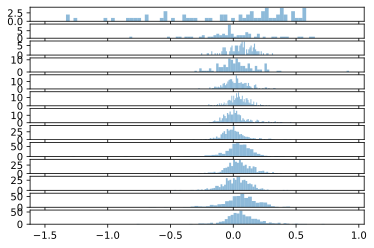

In [34]:
fig, ax = plt.subplots(13, 1, sharex=True)
i = 0
weights = []
biases = []
for index, layer in enumerate(net.model.features.children()):
    if isinstance(layer, torch.nn.Conv2d):
        print(index, layer)
        weight = (torch.sum(layer.weight)/layer.out_channels).item()
        bias = (torch.sum(layer.bias)/layer.out_channels).item()
        print("mean of weight:", weight)
        print("mean of bias:", bias)
        weights.append(weight)
        biases.append(bias)
        ax[i].hist(layer.bias.detach().cpu().numpy().reshape(-1), label=index, alpha=0.5, bins=64)
#         plt.legend(loc="best")
        i = i+1
        print("-"*50)

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
sns.set(color_codes=True)

In [46]:
import pandas
df = pandas.DataFrame(data={"weight": weights, "bias": biases})

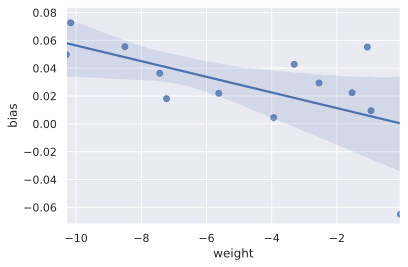

In [47]:
sns.regplot(x="weight", y="bias", data=df);

In [48]:
ckpt

OrderedDict([('model.features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-

In [58]:
torchvision.models.vgg16(pretrained=True).state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [50]:
import torchvision

In [59]:
vgg11 = torchvision.models.vgg11()

In [61]:
summary(vgg11.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,